In [23]:
import sys
sys.path.append('..')
import tangles
import cost_functions
import cut_finding
import importlib
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.cluster import KMeans
import sklearn.metrics
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from collections import Counter
from sklearn.datasets import make_blobs

import sklearn.metrics
import tqdm
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
import importlib
import time
import cut_finding
import plotting
import dataset_generation
from numpy_kmeans import NumpyKMeans

def reload():
    importlib.reload(tangles)
    importlib.reload(cost_functions)
    importlib.reload(cut_finding)
    importlib.reload(tangles)
    importlib.reload(plotting)
    importlib.reload(dataset_generation)


In [42]:
from functools import partial
reload()

runs = 100

seed_start = np.random.randint(0, 100000)
seeds = range(seed_start, seed_start + runs)

results = []
k=50

axis_parallel_cut_function = partial(cut_finding.axis_parallel_cuts, k=k)

def means_func(size):
    return 12 * np.random.random(size=size)


range_axis_parallel = partial(cut_finding.range_axis_parallel, agreement_param=160)

dimensions = 2
min_distance = 3
agreements = []


for n_clusters in [2, 3, 5, 7]:
    for data_size in [1000]:

        for i in tqdm.tqdm(range(runs)):

            np.random.seed(seeds[i])

            data, labels = dataset_generation.create_2d_test_data(
                means_func=means_func,
                n_clusters=n_clusters,
                dimensions=dimensions,
                scales=np.random.choice([0.5, 2], size=(n_clusters, 2)),
                weights = np.ones(n_clusters),
                num_samples=data_size,
                min_distance=min_distance
            )

            MinMaxScaler = sklearn.preprocessing.MinMaxScaler()
            data = MinMaxScaler.fit_transform(data)

            agreement_param = (min(Counter(labels).values()) * (0.4))
            agreement_param /= len(labels)

            models = {
                # "TanglesCount": partial(tangles.TangleClustering,
                #                             cost_class=cost_functions.BorderDistances,
                #                             cut_function=range_axis_parallel,
                #                             agreement_param=agreement_param
                #                             ),
                # "TanglesRecomputeCount": partial(tangles.TangleClustering,
                #                             cost_class=cost_functions.BorderDistances,
                #                             cut_function=range_axis_parallel,
                #                             agreement_param=agreement_param,
                #                             recompute_costs_on_split=True
                #                             ),
                "Tangles": partial(tangles.TangleClustering,
                                            cost_class=cost_functions.BorderDistances,
                                            cut_function=axis_parallel_cut_function,
                                            agreement_param=agreement_param
                                            ),
                "TanglesRecompute": partial(tangles.TangleClustering,
                                            cost_class=cost_functions.BorderDistances,
                                            cut_function=axis_parallel_cut_function,
                                            agreement_param=agreement_param,
                                            recompute_costs_on_split=True
                                            ),
                "KMeans": NumpyKMeans,
            }

            for model_name, Model in models.items():

                starttime = time.time()
                if model_name == "GaussianMixture":
                    model = Model(n_components=n_clusters)
                else:
                    model = Model(n_clusters=n_clusters)
                preds = model.fit_predict(data)
                time_ = time.time() - starttime

                clusters_found = len(set(preds))

                nmi = sklearn.metrics.normalized_mutual_info_score(labels, preds)
                results.append([
                    model_name,  n_clusters, data_size, nmi, seeds[i], time_,  clusters_found])


100%|██████████| 100/100 [00:12<00:00,  7.82it/s]


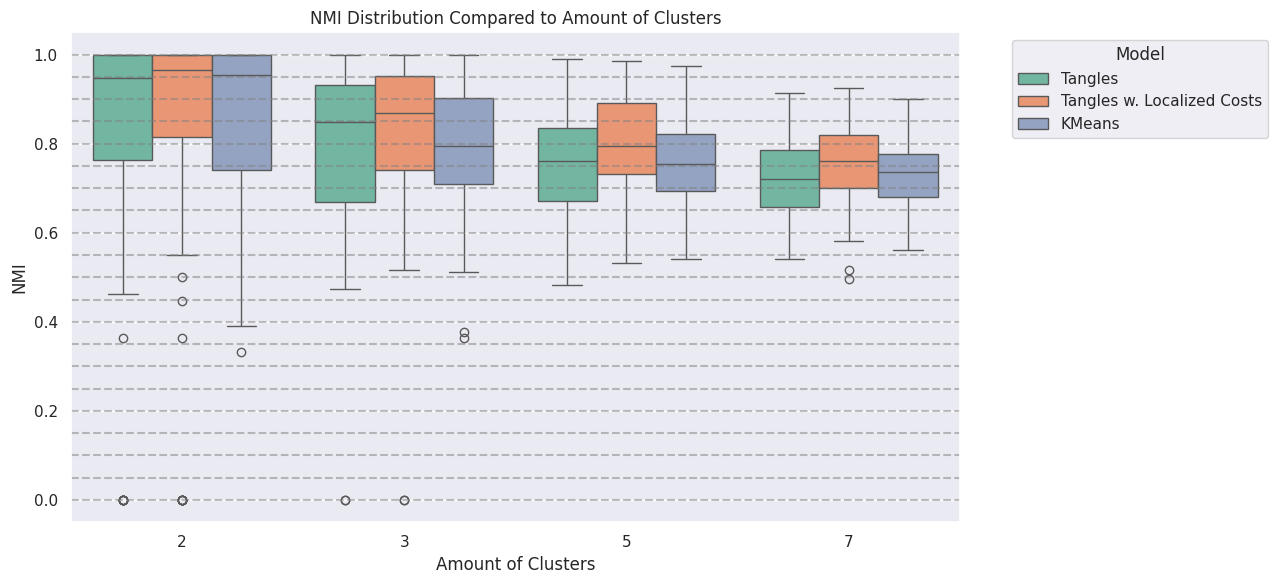

In [43]:
import seaborn as sns
reload()
sns.set_theme(style='darkgrid')

df = pd.DataFrame(results, columns=["Model", "Amount of Clusters", "Data-Size",
                                    "NMI", "Seed", "Time", "Clusters Found"])

df["Model"] = df["Model"].replace("TanglesRecompute", "Tangles w. Localized Costs")

plotting.BoxPlot(df).nmi(x="Amount of Clusters")

plt.savefig('plots/recompute_boxplot.png', dpi=300, bbox_inches='tight')


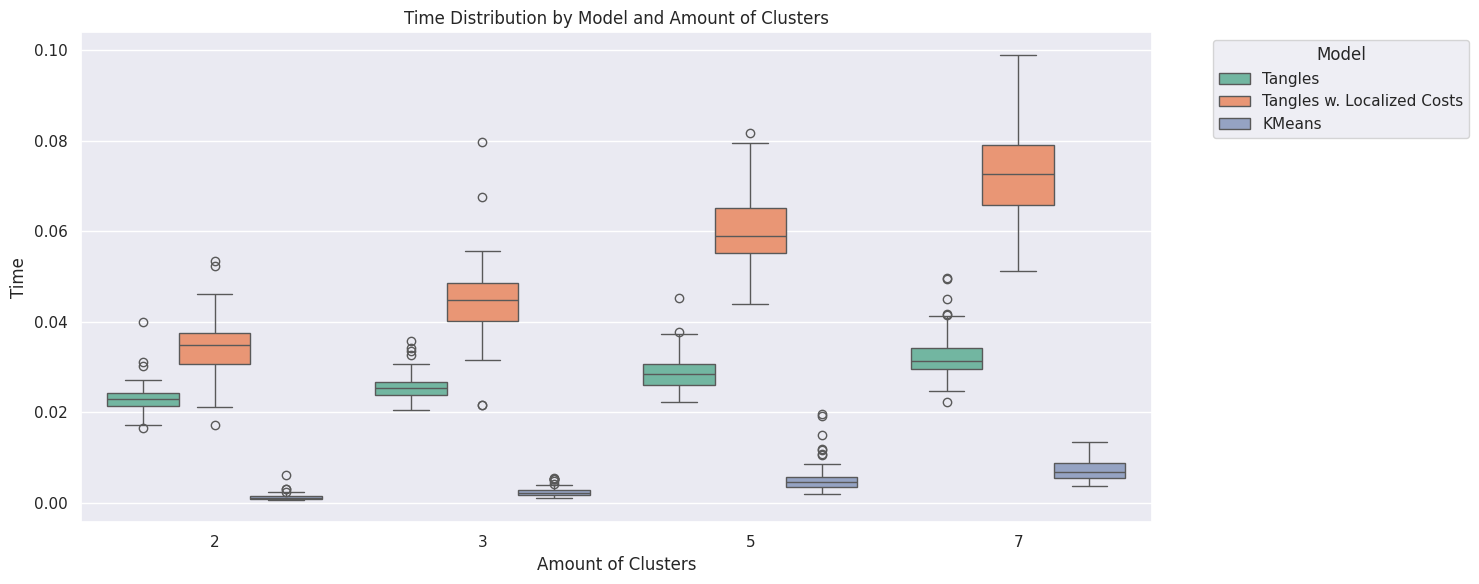

In [44]:
plotting.BoxPlot(df).time(x="Amount of Clusters")
plt.savefig('plots/recompute_boxplot_time.png', dpi=300, bbox_inches='tight')

In [45]:
from functools import partial
reload()

runs = 100

results2 = []

def means_func(size):
    return 10 * np.random.random(size=size)

axis_parallel_cut_function = partial(cut_finding.axis_parallel_cuts, k=50)


for n_clusters in [5,]:
    for data_size in [1000]:
        for i in range(5, 19):
            agreement_frac = i/20
            for i in tqdm.tqdm(range(runs)):
                np.random.seed(seeds[i])
                np.random.seed(random.randint(0, 100000))

                data, labels = dataset_generation.create_2d_test_data(
                    means_func=means_func,
                    n_clusters=n_clusters,
                    dimensions=dimensions,
                    scales=np.random.choice([0.5, 2], size=(n_clusters, 2)),
                    weights=np.array([1, 1, 1, 1, 1]),
                    num_samples=data_size,
                    min_distance=3
                )

                MinMaxScaler = sklearn.preprocessing.MinMaxScaler()
                data = MinMaxScaler.fit_transform(data)

                agreement_param = (min(Counter(labels).values()) * (agreement_frac))

                models = {
                    "Tangles": partial(tangles.TangleClustering,
                                                cost_class=cost_functions.BorderDistances,
                                                cut_function=axis_parallel_cut_function,
                                                agreement_param=agreement_param
                                                ),
                    "TanglesRecompute": partial(tangles.TangleClustering,
                                                cost_class=cost_functions.BorderDistances,
                                                cut_function=axis_parallel_cut_function,
                                                agreement_param=agreement_param,
                                                recompute_costs_on_split=True,
                                                ),
                }

                for model_name, Model in models.items():
                    starttime = time.time()
                    model = Model(n_clusters=n_clusters)
                    preds = model.fit_predict(data)
                    time_ = time.time() - starttime

                    nmi = sklearn.metrics.normalized_mutual_info_score(labels, preds)
                    # print(model_name, nmi)
                    clusters_found = len(np.unique(preds))
                    results2.append([
                        model_name,  n_clusters, data_size, nmi, seeds[i], time_, clusters_found, str(agreement_frac)])


100%|██████████| 100/100 [00:07<00:00, 14.19it/s]


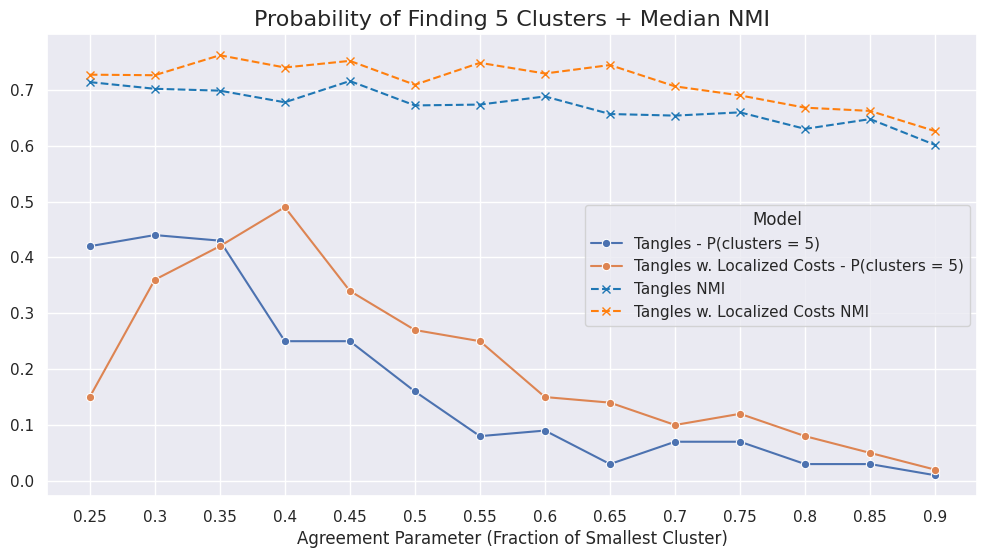

In [47]:
df2 = pd.DataFrame(results2, columns=["Model", "Clusters", "Data-Size",
                                    "NMI", "Seed", "Time", "Clusters-Found", "Agreement"])


df2["Model"] = df2["Model"].replace("TanglesRecompute", "Tangles w. Localized Costs - P(clusters = 5)")

df2["Model"] = df2["Model"].replace("Tangles", "Tangles - P(clusters = 5)")

prob_5_clusters = df2[df2['Clusters-Found'] == 5].groupby(['Model', 'Agreement']).size() / df2.groupby(['Model', 'Agreement']).size()
prob_5_clusters = prob_5_clusters.reset_index(name='Probability')



avg_nmi = df2.groupby(['Model', 'Agreement'])['NMI'].median().reset_index()

prob_5_clusters = prob_5_clusters.merge(avg_nmi, on=['Model', 'Agreement'])

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=prob_5_clusters, x='Agreement', y='Probability', hue='Model', marker='o')

legend = ax.get_legend()
legend_labels = [text.get_text() for text in legend.get_texts()]

for i, model in enumerate(prob_5_clusters['Model'].unique()):
    model_data = prob_5_clusters[prob_5_clusters['Model'] == model]
    plt.plot(model_data['Agreement'], model_data['NMI'], marker='x', linestyle='--',
             label=f"{model.split('- P')[0]}NMI", color='#1f77b4' if i == 0 else '#ff7f0e')

plt.title('Probability of Finding 5 Clusters + Median NMI', fontsize=16)
plt.xlabel('Agreement Parameter (Fraction of Smallest Cluster)')

plt.ylabel('')
plt.legend(title='Model')
# plt.tight_layout()
plt.savefig('plots/recompute_agreement.png', dpi=300, bbox_inches='tight')
plt.show()

# plt.show()